<a href="https://colab.research.google.com/github/meiqingli/Geospatial-Software-Design/blob/master/D_Lab_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Time-Series Satellite Images with Google Earth Engine Python API

by: Meiqing Li (meiqing@berkeley.edu), D-Lab Data Science Fellow

This notebook demonstrates the process to filter, classify, resample, and visualiza time-series satellite images using Google Earth Engine Python API. 

### API Setup: import, authenticate and initialize

Beofre running the code, we need to first import the Google Earth Enginer API. Since the Earth Engine API is installed by default in Google Colaboratory, I don't need to install it here. 

In [ ]:
import ee

This will trigger the authentication flow of Google Earth Engine. We will follow the url, which will bring us to the authentication steps. Copy and paste the provided token. Once it is successfullly authorized, we can proceed with our analysis. 

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=qarGOe1_xz4TpOEUH4xqrwJrHKR9yy086ZdxS5jqG_4&tc=tSv6f70TYbvHpkgfYk6ljctk0jePRrLzWzY0tM0o5Ok&cc=fisVrnGP3OXnuD3IHZ6GfE0tfG1xOGNfRmf4Vlg7d4U

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk4ZTtltXseods0gG2ZkfqPJwSLRbmro9RE4fUiKv4ILPfgDD9u3r1o

Successfully saved authorization token.


### Explore Earth Engine Data Catalog

There are a lot of things we can explore wih Google Earth Engine. 
[The Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog) 

https://code.earthengine.google.com/1ec1d414a4c5b03bbb0a7d6c19b5a748
https://code.earthengine.google.com/291961fe8406ca4c75ecea4ef3f33435

VIIRS - Nighttime Light Image


In [ ]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


### Import Features

In [ ]:
# I have uploaded CA county and state boundaries through GEE console (add more description here)
CACounty = ee.FeatureCollection("projects/spherical-depth-278922/assets/California_County_Boundaries")
CAState = ee.FeatureCollection("projects/ee-meiqingli/assets/CAState")

#### DMSP/OLS

https://developers.google.com/earth-engine/datasets/catalog/NOAA_DMSP-OLS_NIGHTTIME_LIGHTS#bands

https://developers.google.com/earth-engine/datasets/catalog/BNU_FGS_CCNL_v1

In [ ]:
## DMSP OLS Nighttime Lights (1992-01-01 - 2014-01-01)
# select band and filter date
DMSP = ee.ImageCollection('BNU/FGS/CCNL/v1').select('b1').filterDate('1992-01-01', '2014-01-01')

#### VIIRS

https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG#description

In [ ]:
## VIIRS Nighttime Lights (2014-01-01 - 2022-11-01)
# select band and filter date
VIIRS = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad').filterDate('2014-01-01', '2022-01-01')

### Get time-series data for a location

UC Berkeley: [37.8719, -122.2585]

In [ ]:
## Calculate the mean value around a location using the `getRegion()` method
# DMSP/OLS
poi = ee.Geometry.Point([-122.3790, 37.6213]) # note lon, lat
scale = 30

DMSP_poi = DMSP.getRegion(poi, scale).getInfo()

# preview the result
DMSP_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'b1'],
 ['DMSP1992v1',
  -122.37897337582122,
  37.621309351632945,
  694224000000,
  67.76784695621606],
 ['DMSP1993v1',
  -122.37897337582122,
  37.621309351632945,
  725846400000,
  56.66487062392774],
 ['DMSP1994v1',
  -122.37897337582122,
  37.621309351632945,
  757382400000,
  81.95031347136096],
 ['DMSP1995v1',
  -122.37897337582122,
  37.621309351632945,
  788918400000,
  91.53101235005826]]

In [ ]:
# VIIRS
VIIRS_poi = VIIRS.getRegion(poi, scale).getInfo()

# preview the result
VIIRS_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'avg_rad'],
 ['20140101',
  -122.37897337582122,
  37.621309351632945,
  1388534400000,
  55.463462829589844],
 ['20140201',
  -122.37897337582122,
  37.621309351632945,
  1391212800000,
  72.19701385498047],
 ['20140301',
  -122.37897337582122,
  37.621309351632945,
  1393632000000,
  60.484066009521484],
 ['20140401',
  -122.37897337582122,
  37.621309351632945,
  1396310400000,
  63.16453170776367]]

Transform to pandas dataframe

In [ ]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [ ]:
dmsp_poi = ee_array_to_df(DMSP_poi,['b1'])
viirs_poi = ee_array_to_df(VIIRS_poi,['avg_rad'])

viirs_poi.head()

,time,datetime,avg_rad
0,1388534400000,2014-01-01,55.463463
1,1391212800000,2014-02-01,72.197014
2,1393632000000,2014-03-01,60.484066
3,1396310400000,2014-04-01,63.164532
4,1398902400000,2014-05-01,52.005966


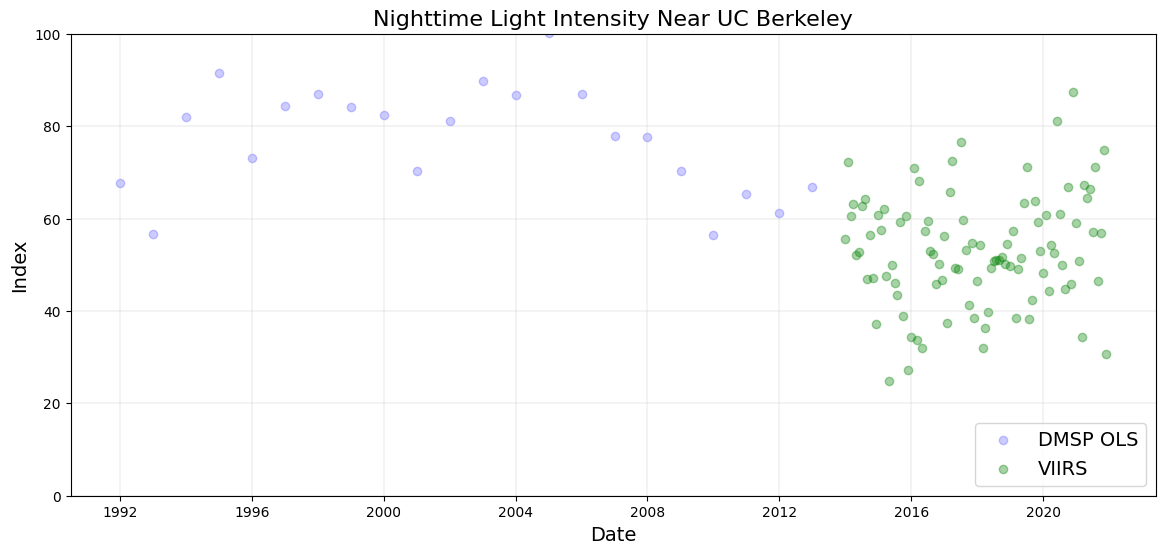

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(dmsp_poi['time'].apply(float))  
x_data_r = np.asanyarray(viirs_poi['time'].apply(float))  

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(dmsp_poi['b1'].apply(float)) 
y_data_r = np.asanyarray(viirs_poi['avg_rad'].apply(float))  

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(dmsp_poi['datetime'], dmsp_poi['b1'],
           c='blue', alpha=0.2, label='DMSP OLS')
ax.scatter(viirs_poi['datetime'], viirs_poi['avg_rad'],
           c='green', alpha=0.35, label='VIIRS')


# Add some parameters.
ax.set_title('Nighttime Light Intensity Near UC Berkeley', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index', fontsize=14)
ax.set_ylim(0, 100)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

## Static image

In [ ]:
alameda = CACounty.filterMetadata("COUNTY_NAM","equals", "Alameda").first().geometry()

In [ ]:
# Import the Image function from the IPython.display module.
from IPython.display import Image

# Display a thumbnail of global nighttime light.
Image(url = DMSP.mean()
  .getThumbURL({'min': 0, 'max': 63, 'region': alameda, 'dimensions': 512,
                'palette': ['000044','ffff00','ffffff']}))

In [ ]:
# Import the Image function from the IPython.display module.
from IPython.display import Image

# Display a thumbnail of global nighttime light.
Image(url = VIIRS.mean()
  .getThumbURL({'min': 0, 'max': 63, 'region': alameda, 'dimensions': 512,
                'palette': ['000044','ffff00','ffffff']}))

### Export a GEOTIFF file (to edit)

Save as a GEOTIFF file in Google Drive.

In [ ]:
VIIRS_img = VIIRS.mean()
DMSP_img = DMSP.mean()

task = ee.batch.Export.image.toDrive(image=VIIRS_img,
                                     description='night light intensity in Aladema',
                                     scale=30,
                                     region=alameda,
                                     fileNamePrefix='VIIRS_alameda',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

In [ ]:
task.status()

{'state': 'READY',
 'description': 'night light intensity in Aladema',
 'creation_timestamp_ms': 1680808209198,
 'update_timestamp_ms': 1680808209198,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'DI524QOUIG3L63LUOS4OSBQW',
 'name': 'projects/earthengine-legacy/operations/DI524QOUIG3L63LUOS4OSBQW'}

Get a link to download a GEOTIFF file.

In [ ]:
link = VIIRS_img.getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': alameda})
print(link)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c77304da439ca7ea4dd63cd704931771-bf1251c054bf2d37228090fcfbbf431f:getPixels


## Interactive map

In [ ]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 63,
  'palette': ['000044','ffff00','ffffff']}

# Create a folium map object.
my_map = folium.Map(location=[38, -121], zoom_start=5.5)

# Arrange layers inside a list
ee_tiles = [DMSP_img, VIIRS_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [vis_params, vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['DMSP', 'VIIRS']

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)


# Display the map.
display(my_map)

## References

*  [EE API Colab Setup](https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb) 
*   [EE Python API Tutorial](https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/intro-to-python-api/index.ipynb)
